# Transform Consistency Loss

In [34]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

A few things to fix:
- Understanding the paper
- Loading the data
- Converting the handedness
- Converting between different extrinsic formats and choosing great names for them
- Understanding the sources of NaN - perspective division and taking a log of a negative number

How I was able to do all of these things in 1/2 a day:
- Writing lots of little tests

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

In [35]:
def load_data_as_memmap(filename, directory):
    directory = pathlib.Path(directory)
    dataset = np.load(filename)
        
    output = {
        'K': dataset['K'],
        'transforms': dataset['transforms'],
    }
    
    # Send the RGB & depth data to a file on disk to avoid OOM
    for key in ('rgbs', 'depths'):
        data = dataset[key]
        filename = directory / f'{key}.npy'
        fp = np.memmap(filename, dtype='float32', mode='w+', shape=data.shape)
        fp[:] = data[:]
        output[key] = np.memmap(filename, dtype='float32', mode='r', shape=data.shape)
    return output

In [36]:
def relative_pose(pose_a, pose_b):
    R_a, t_a = pose_a
    R_b, t_b = pose_b
    R_ab = R_b @ R_a.mT
    t_ab = t_b - R_ab @ t_a
    return R_ab, t_ab

In [37]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']
        

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_q = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255
        image_0 = torch.from_numpy(self.rgbs[idx+1].copy()).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()).permute(2, 0, 1) /255
        # Our depth images i
        depth_q = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_0 = torch.from_numpy(self.depths[idx+1].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z ->-z,-x,-y
        axes = torch.tensor([
            [ 1, 0, 0, 0.],
            [ 0, 0, 1, 0.],
            [ 0, 1, 0, 0.],
            [ 0, 0, 0, 1.],
        ]).double()
        axes = torch.tensor([
            [ 0,-1, 0, 0.],
            [ 0, 0,-1, 0.],
            [-1, 0, 0, 0.],
            [ 0, 0, 0, 1.],
        ]).double()


        # Our poses
        extrinsic_q = axes @ torch.from_numpy(self.transforms[idx+0])
        extrinsic_0 = axes @ torch.from_numpy(self.transforms[idx+1])
        extrinsic_1 = axes @ torch.from_numpy(self.transforms[idx+2])

        R_q = extrinsic_q[:3, :3].float()
        t_q = extrinsic_q[:3,[3]].float()

        R_0 = extrinsic_0[:3, :3].float()
        t_0 = extrinsic_0[:3,[3]].float()

        R_1 = extrinsic_1[:3, :3].float()
        t_1 = extrinsic_1[:3,[3]].float()

        pose_q0 = relative_pose((R_q, t_q), (R_0, t_0))
        pose_q1 = relative_pose((R_q, t_q), (R_1, t_1))
        pose_01 = relative_pose((R_0, t_0), (R_1, t_1))

        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        resize = torchvision.transforms.Resize((600,800))
        return self.K.unsqueeze(0), resize.forward(image_q), resize.forward(image_0), resize.forward(image_1),\
                                    resize.forward(depth_q.unsqueeze(0)).squeeze(), resize.forward(depth_0.unsqueeze(0)).squeeze(), resize.forward(depth_1.unsqueeze(0)).squeeze(),\
                                    pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

### Testing the DataLoader

In [29]:
memmap = load_data_as_memmap('data.npz', tempfile.mkdtemp())

In [38]:
dataset = CarlaTriplesDataset(memmap)

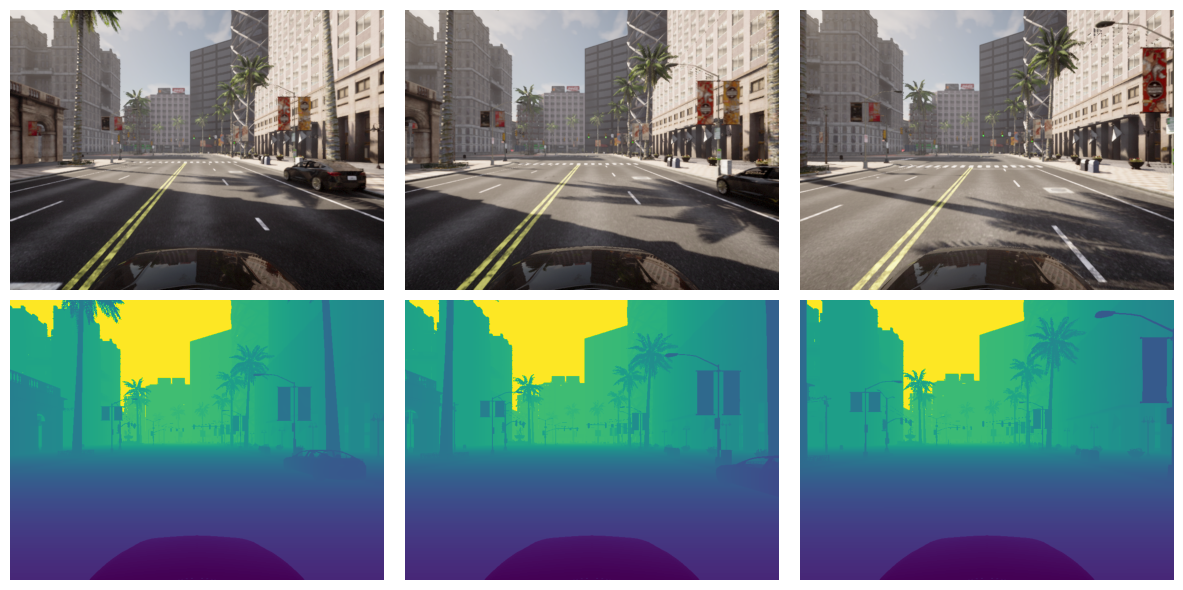

In [40]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax in axs.ravel():
    ax.axis('off')
axs[0, 0].imshow(image_q.permute(1, 2, 0))
axs[0, 1].imshow(image_0.permute(1, 2, 0))
axs[0, 2].imshow(image_1.permute(1, 2, 0))
axs[1, 0].imshow(torch.log(depth_q))
axs[1, 1].imshow(torch.log(depth_0))
axs[1, 2].imshow(torch.log(depth_1))
plt.tight_layout()
plt.show()

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [41]:
def invert_pose(pose):
    R, t = pose
    return R.mT, -(R.mT @ t)

In [42]:
def transform_from_pose(pose):
    R, t = pose
    if len(R.shape) == 2:
        R, t = R.unsqueeze(0), t.unsqueeze(0)
    T = torch.zeros(len(R), 4, 4, device=R.device)
    T[..., :3, :3] = R
    T[..., :3,  3] = t[..., 0]
    T[...,  3,  3] = 1.0
    return T

In [43]:
def pose_from_params(params):
    return roma.rotvec_to_rotmat(params[..., :3]), params[..., 3:, None]

In [44]:
def params_from_pose(pose):
    R, t = pose
    return torch.cat([roma.rotmat_to_rotvec(R), t[..., :, 0]], dim=-1)

In [45]:
transform_from_pose(invert_pose(pose_from_params(params_from_pose((torch.zeros(2, 3, 3), torch.ones(2, 3, 1))))))
# transform_from_params(torch.zeros(6))

tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -8.7423e-08,  1.0000e+00],
         [ 0.0000e+00,  8.7423e-08, -1.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -8.7423e-08,  1.0000e+00],
         [ 0.0000e+00,  8.7423e-08, -1.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

## Perspective Geometry

In [46]:
def perspective(points, epsilon=1e-8):
    """|
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [47]:
def transform(points, pose):
    """
    Project points to camera reference frame
    """
    R, t = pose
    return R @ points + t

In [48]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [49]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [50]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [51]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [52]:
def reproject(depth, image, K, pose):
    """
    Backproject a depth map and transform it into the reference frame of a new camera
    defined by K, R, t by resampling the image.
    """
    points_3d = backproject(depth, K)
    points_3d = transform(points_3d, pose)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output

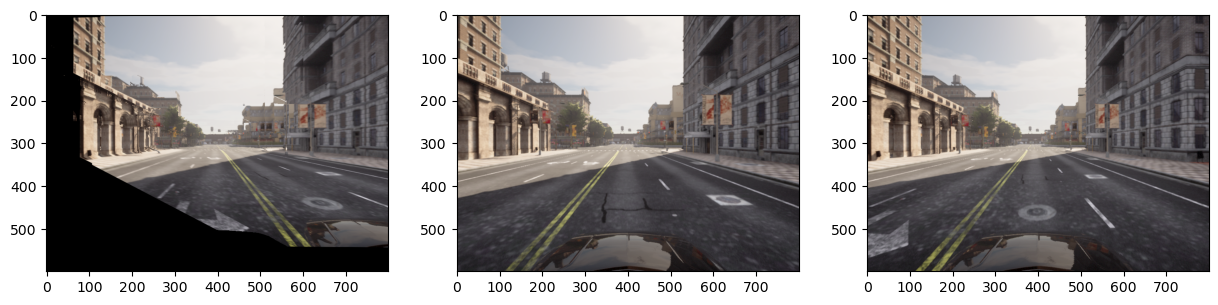

In [53]:
#test for relative_pose, ref image 0 with extrinsic 0 , ref image1 with extrinsic 1.
# map reference image 0 to reference image 1
class testCarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']
        

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_q = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255
        image_0 = torch.from_numpy(self.rgbs[idx+1].copy()).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()).permute(2, 0, 1) /255
        # Our depth images i
        depth_q = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_0 = torch.from_numpy(self.depths[idx+1].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z ->-z,-x,-y

        axes = torch.tensor([
            [ 0,-1, 0, 0.],
            [ 0, 0,-1, 0.],
            [-1, 0, 0, 0.],
            [ 0, 0, 0, 1.],
        ]).double()


        # Our poses
        extrinsic_q = axes @ torch.from_numpy(self.transforms[idx+0])
        extrinsic_0 = axes @ torch.from_numpy(self.transforms[idx+1])
        extrinsic_1 = axes @ torch.from_numpy(self.transforms[idx+2])

        R_q = extrinsic_q[:3, :3].float()
        t_q = extrinsic_q[:3,[3]].float()

        R_0 = extrinsic_0[:3, :3].float()
        t_0 = extrinsic_0[:3,[3]].float()

        R_1 = extrinsic_1[:3, :3].float()
        t_1 = extrinsic_1[:3,[3]].float()

        pose_q0 = relative_pose((R_q, t_q), (R_0, t_0))
        pose_q1 = relative_pose((R_q, t_q), (R_1, t_1))
        pose_01 = relative_pose((R_0, t_0), (R_1, t_1))

        pose_0 = extrinsic_0[:3, :3].float(), extrinsic_0[:3,[3]].float()
        pose_1 = extrinsic_1[:3, :3].float(), extrinsic_1[:3,[3]].float()
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        resize = torchvision.transforms.Resize((600,800))
        return self.K.unsqueeze(0), resize.forward(image_q), resize.forward(image_0), resize.forward(image_1),\
                                    resize.forward(depth_q.unsqueeze(0)).squeeze(), resize.forward(depth_0.unsqueeze(0)).squeeze(), resize.forward(depth_1.unsqueeze(0)).squeeze(),\
                                    pose_q0, pose_q1, pose_01,pose_0,pose_1
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01
testDataset = testCarlaTriplesDataset(memmap)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01, pose_0,pose_1= testDataset[21]  # 71, 65, 21, 5
pose_01 = relative_pose(pose_q0, pose_q1)
image_01 = reproject(depth_0,image_0.unsqueeze(0), K, pose_01).squeeze()
fig, axs = plt.subplots(1,3, figsize=(15,8))
axs[0].imshow(image_01.permute(1,2,0))
axs[1].imshow(image_1.permute(1,2,0))
axs[2].imshow(image_0.permute(1,2,0))

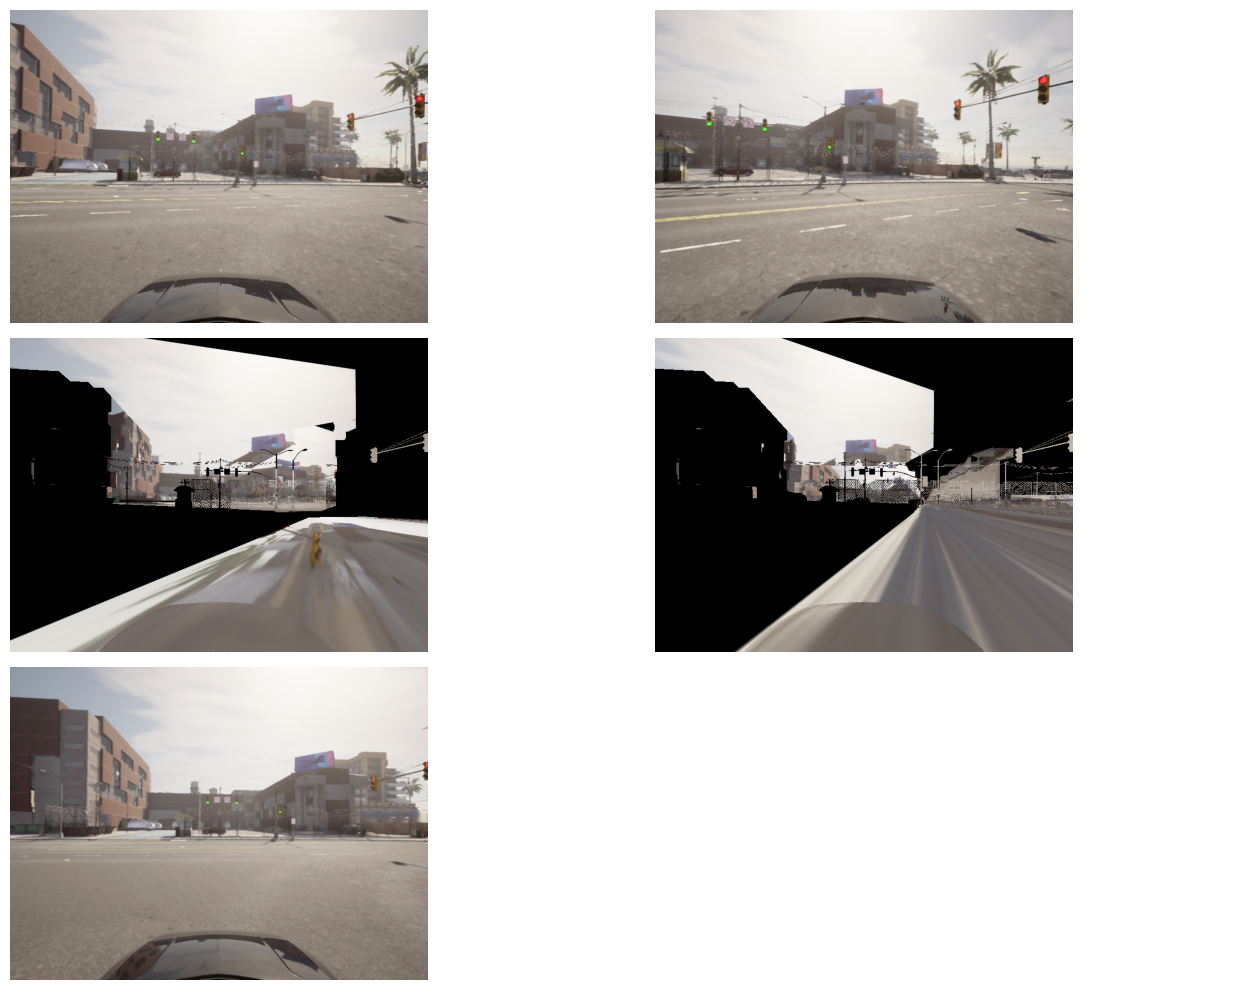

In [54]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[65]  # 71, 65, 21, 5

image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, pose_q0).squeeze()
image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, pose_q1).squeeze()

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].imshow(image_0.permute(1,2,0))
axs[0, 1].imshow(image_1.permute(1,2,0))
axs[1, 0].imshow(image_q0.permute(1,2,0))
axs[1, 1].imshow(image_q1.permute(1,2,0))
axs[2, 0].imshow(image_q.permute(1,2,0))
plt.tight_layout()
plt.show()

### Testing Perspective Geometry

Let's see if we can project image_0 into image_1.

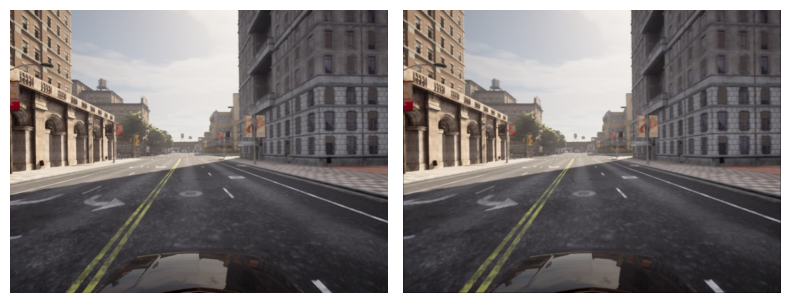

In [301]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[21]

identity = torch.eye(3), torch.zeros(3, 1)
image_r = reproject(depth_q, image_q.unsqueeze(0), dataset.K, identity).squeeze()

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for a in axs.ravel():
    a.axis('off')
axs[0].imshow(image_q.permute(1,2,0))
axs[1].imshow(image_r.permute(1,2,0))
plt.tight_layout()
plt.show()

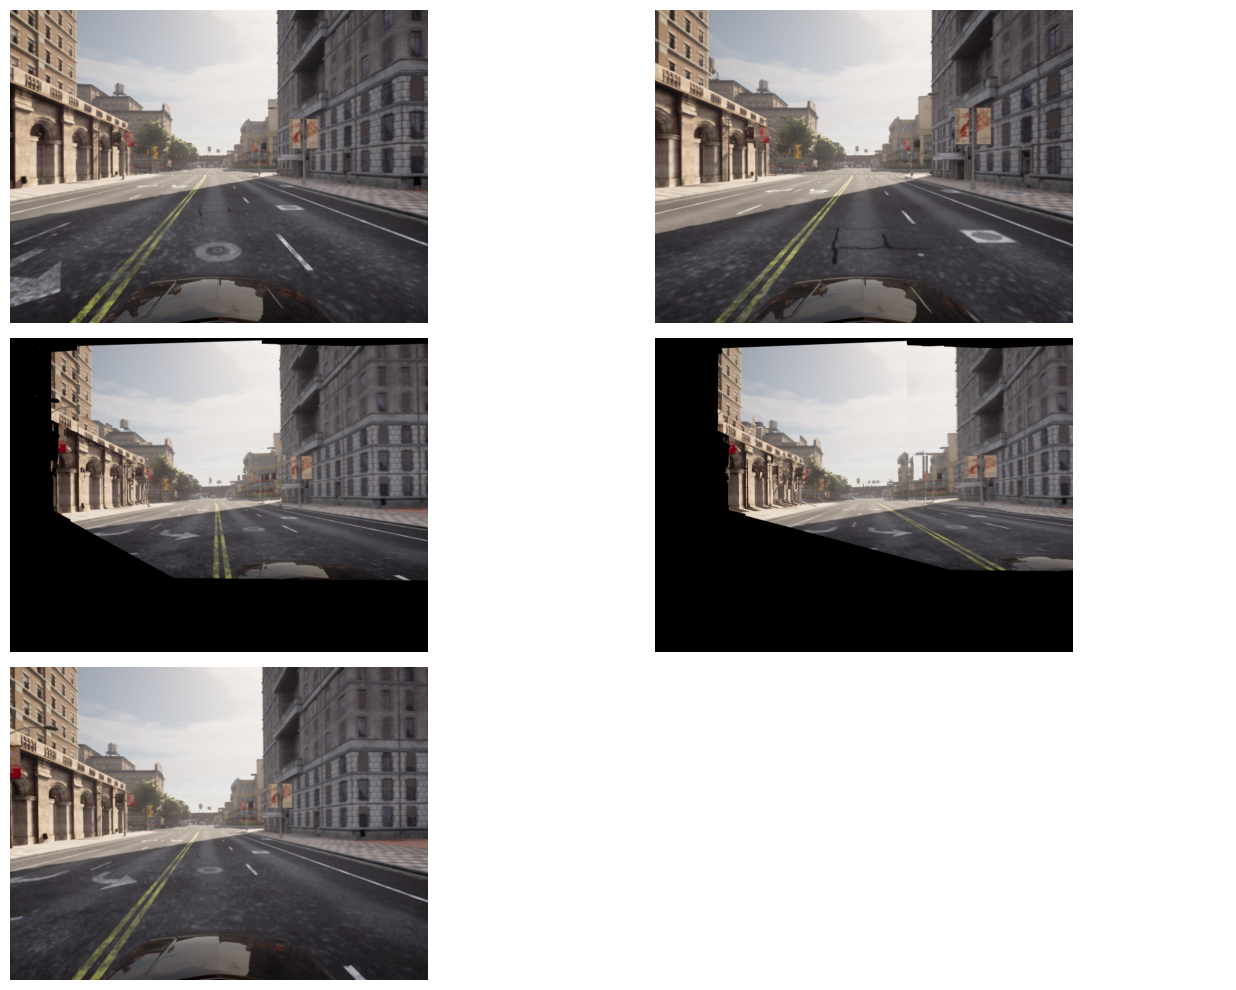

In [302]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[21]  # 71, 65, 21, 5

image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, pose_q0).squeeze()
image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, pose_q1).squeeze()

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].imshow(image_0.permute(1,2,0))
axs[0, 1].imshow(image_1.permute(1,2,0))
axs[1, 0].imshow(image_q0.permute(1,2,0))
axs[1, 1].imshow(image_q1.permute(1,2,0))
axs[2, 0].imshow(image_q.permute(1,2,0))
plt.tight_layout()
plt.show()

In [285]:
# At frame 5, the car is driving along the positive z axis
# At frame 21, we think the car is driving along the negative x axis. However, the car is actually driving 
pose_q0[1]

tensor([[-3.7845e+00],
        [-4.1748e-02],
        [ 4.4107e-06]])

In [287]:
# At frame 5, the car is driving along the positive z axis
# At frame 21, we think the car is driving along the negative x axis. However, the car is actually driving 
pose_q0[1]

tensor([[-1.2704e-01],
        [ 4.0086e+00],
        [ 1.1575e-04]])

## Gauss-Newton

In [37]:
def gauss_newton(x, residuals, damping=1., iterations=5):
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        r = torch.atleast_1d(residuals(x))
        # We need nan_to_num in case there are no errors..!
        J = torch.atleast_2d(torch.autograd.functional.jacobian(residuals, x)).nan_to_num(0)
        # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
        u = torch.linalg.lstsq(J.mT @ J, J.mT @ r).solution
        # Update x, but do nothing if the solution is bad
        x = x - damping * u.nan_to_num(0)
        if J.sum() ==0:
            print("jacobian is 0", "\n x", x, "\nr", r, "\nJ", J)
    return x

In [22]:
def gauss_newton_batch(xs, residuals, damping, iterations):
    output = torch.zeros_like(xs)
    for i, x in enumerate(xs):
      output[i,:] = gauss_newton(x, residuals, damping, iterations)
    
    return output

In [41]:
def align_feature_maps(K, features_q, saliency_q, features_r, saliency_r, depth_r, gamma):
    def residuals(params):
        pose = pose_from_params(params)
        features_estimated = reproject(depth_r, features_r, K, pose)
        saliency_estimated = reproject(depth_r, saliency_r, K, pose)
        errors = saliency_q * saliency_estimated * huber_norm(features_q - features_estimated, gamma)
        print("error.sum()",errors.sum())
        return errors.sum()
    return residuals

## Loss Functions

In [24]:
def huber_norm(x, gamma):
    abs_x = torch.abs(x)
    mask1 = abs_x <= gamma
    mask2 = abs_x > gamma
    mask1 = mask1*0.5*(x**2)
    mask2 = mask2*gamma*(abs_x-gamma/2)
    result = torch.sum(mask1+mask2)
    return result

## Transform Consistency Loss

Looking carefully at the definition of Transform Consistency Loss:

$$
L_{\mathrm{c}}\left(T_{q, r_0}^*, T_{q, r_1}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1}\left(T_{q, r_1}^k\right)^{-1} T_{q, r_0}^*\right)\right\|_1 .
$$

Transform Consistency Loss depends on taking the logarithm of a SE(3) matrix. However, SE(3) matrices have negative numbers that we need to deal with.

To compute the logairthm, we will use the function `se3_log_map` from PyTorch3D. As PyTorch3D is a pain to install, I have just copied the code into `se3.py`.

In [49]:
def transform_consistency_loss(pose_q0, pose_q1, pose_01):
    T_q0 = transform_from_pose(pose_q0)
    T_1q = transform_from_pose(invert_pose(pose_q1))
    T_01 = transform_from_pose(pose_01).to(T_q0.device)

    transform_consistency = T_01 @ T_1q @ T_q0
    return torch.abs(se3_log_map(transform_consistency.mT).mean())
    # return huber_norm(se3_log_map(transform_consistency.mT), 1)

In [26]:
se3_log_map(torch.eye(4).view(1,4,4))

tensor([[0., 0., 0., 0., 0., 0.]])

In [27]:
torch.autograd.set_detect_anomaly(False, check_nan=True)

### Test Transform Consistency

In [50]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]
transform_consistency_loss(pose_q0, pose_q1, pose_01)

tensor(6.2685e-06)

## Transform Accuracy Loss

This is essentially a sanity check using ground truth data that we have available.

$$
L_{\mathrm{a}}\left(T_{r_1, r_0}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1} T_{r_1, r_0}^k\right)\right\|_1
$$

In [51]:
def transform_accuracy_loss(pose_est, pose_inv):
    T_est = transform_from_pose(pose_est)
    T_inv = transform_from_pose(pose_inv).to(T_est.device)
    transform_accuracy = T_est @ T_inv
    return torch.abs(se3_log_map(transform_accuracy.mT).mean())

In [52]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = dataset[5]
transform_accuracy_loss(pose_01, invert_pose(pose_01))

tensor(8.1374e-08)

## Data Loader

In [53]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [54]:
import datetime
from tensorflow import summary
import tensorflow as tf
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + 'batch_size_4_2'
train_summary_writer = summary.create_file_writer(train_log_dir)

In [56]:
# del net
# del optimizer
# del progress
# del image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01, result_q0, result_q1, result_01, pyramid_q, pyramid_1, pyramid_0

torch.cuda.empty_cache()

## Training block

In [57]:
torch.manual_seed(0)

In [58]:
from torch.optim import Adam

net = UNet(3, 17).to(device)
net.train()

loss_history = []

damping = torch.tensor(1, requires_grad=False)

optimizer = torch.optim.Adam([
    {'params': net.parameters(), 'lr': 5e-4}
    # {'params': damping, 'lr': 5e-4},
], lr=5e-4)

epochs = range(0, 50)

for e in epochs:
    
    lambd = 1.0 if e == 0 else 1.0
    
    progress = tqdm.tqdm(dataloader)

    for batch in progress:
        loss = 0
        optimizer.zero_grad()

        # set query image and 2 reference image
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 = batch
        K = K.to(device)
        pose_10 = invert_pose(pose_01)

        # set inital guess as identity rot-vec. and 0 translation
        result_q0 = torch.zeros(len(K), 6, device=device)
        result_q1 = torch.zeros(len(K), 6, device=device)
        result_01 = torch.zeros(len(K), 6, device=device)
        
        pyramid_q = net.forward(image_q.to(device))
        # print("pyramid_q",pyramid_q)
        pyramid_0 = net.forward(image_0.to(device))
        pyramid_1 = net.forward(image_1.to(device))
        levels = [0, 1, 2, 3]
        iterations = [16, 12, 8, 4]

        for level in levels:
            features_q, saliency_q = pyramid_q[level]
            print("features_q",features_q)
            print('saliency_q',saliency_q)
            features_0, saliency_0 = pyramid_0[level]
            features_1, saliency_1 = pyramid_1[level]

            # Resample depth maps for pyramid
            size = features_q.shape[-2:]
            depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)
            depth_1_ = torchvision.transforms.functional.resize(depth_1, size).to(device).unsqueeze(0)

            # Align image_0 to query image
            residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, gamma=0.02)
            result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iterations[level], damping=abs(damping))
            pose_q0_est = pose_from_params(result_q0)

            # Align image_1 to query image
            residuals_q1 = align_feature_maps(K, features_q, saliency_q, features_1, saliency_1, depth_1_, gamma=0.02)
            result_q1 = gauss_newton_batch(result_q1, residuals_q1, iterations=iterations[level], damping=abs(damping))
            pose_q1_est = pose_from_params(result_q1)

            # Compute transform consistency loss
            loss += transform_consistency_loss(pose_q0_est, pose_q1_est, pose_01)
            loss += transform_consistency_loss(pose_q1_est, pose_q0_est, pose_10)

            # Align image_0 to image_1
            residuals_01 = align_feature_maps(K, features_0, saliency_0, features_1, saliency_1, depth_1_, gamma=0.02)
            result_01 = gauss_newton_batch(result_01, residuals_01, iterations=iterations[level], damping=abs(damping))
            pose_01_est = pose_from_params(result_01)

            # Compute transform accuracy loss
            loss += lambd * transform_accuracy_loss(pose_01_est, pose_10)

            if loss.isnan():
                raise ValueError("Loss is NaN!")
        
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.item(), step=e)
        progress.set_postfix({'loss': loss.item(), 'damping': abs(damping.item()), 'lambda': lambd})


c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/498 [00:00<?, ?it/s]

features_q tensor([[[[0.6714, 0.4603, 0.5104,  ..., 0.5944, 0.5944, 0.5944],
          [0.6714, 0.4603, 0.5104,  ..., 0.5944, 0.5944, 0.5944],
          [0.6714, 0.4603, 0.5104,  ..., 0.5944, 0.5944, 0.5944],
          ...,
          [0.6714, 0.4603, 0.5104,  ..., 0.5944, 0.5944, 0.5944],
          [0.6714, 0.4603, 0.5104,  ..., 0.5944, 0.5944, 0.5944],
          [0.6714, 0.4603, 0.5104,  ..., 0.5944, 0.5944, 0.5944]],

         [[0.5218, 0.5170, 0.6233,  ..., 0.4386, 0.4386, 0.4386],
          [0.5218, 0.5170, 0.6233,  ..., 0.4386, 0.4386, 0.4386],
          [0.5218, 0.5170, 0.6233,  ..., 0.4386, 0.4386, 0.4386],
          ...,
          [0.5218, 0.5170, 0.6233,  ..., 0.4386, 0.4386, 0.4386],
          [0.5218, 0.5170, 0.6233,  ..., 0.4386, 0.4386, 0.4386],
          [0.5218, 0.5170, 0.6233,  ..., 0.4386, 0.4386, 0.4386]],

         [[0.4342, 0.5002, 0.3854,  ..., 0.4417, 0.4417, 0.4417],
          [0.4342, 0.5002, 0.3854,  ..., 0.4417, 0.4417, 0.4417],
          [0.4342, 0.5002, 0.38

  0%|          | 1/498 [00:03<31:58,  3.86s/it, loss=3.07e+10, damping=1, lambda=1]

features_q tensor([[[[0.5480, 0.6141, 0.4873,  ..., 0.4694, 0.4694, 0.4694],
          [0.5480, 0.6141, 0.4873,  ..., 0.4694, 0.4694, 0.4694],
          [0.5480, 0.6141, 0.4873,  ..., 0.4694, 0.4694, 0.4694],
          ...,
          [0.5480, 0.6141, 0.4873,  ..., 0.4694, 0.4694, 0.4694],
          [0.5480, 0.6141, 0.4873,  ..., 0.4694, 0.4694, 0.4694],
          [0.5480, 0.6141, 0.4873,  ..., 0.4694, 0.4694, 0.4694]],

         [[0.4328, 0.5207, 0.5684,  ..., 0.4539, 0.4539, 0.4539],
          [0.4328, 0.5207, 0.5684,  ..., 0.4539, 0.4539, 0.4539],
          [0.4328, 0.5207, 0.5684,  ..., 0.4539, 0.4539, 0.4539],
          ...,
          [0.4328, 0.5207, 0.5684,  ..., 0.4539, 0.4539, 0.4539],
          [0.4328, 0.5207, 0.5684,  ..., 0.4539, 0.4539, 0.4539],
          [0.4328, 0.5207, 0.5684,  ..., 0.4539, 0.4539, 0.4539]],

         [[0.6096, 0.5515, 0.4537,  ..., 0.4456, 0.4456, 0.4456],
          [0.6096, 0.5515, 0.4537,  ..., 0.4456, 0.4456, 0.4456],
          [0.6096, 0.5515, 0.45

  0%|          | 2/498 [00:07<31:52,  3.86s/it, loss=3.58e+10, damping=1, lambda=1]

features_q tensor([[[[0.4414, 0.4502, 0.4972,  ..., 0.4722, 0.4722, 0.4722],
          [0.4414, 0.4502, 0.4972,  ..., 0.4722, 0.4722, 0.4722],
          [0.4414, 0.4502, 0.4972,  ..., 0.4722, 0.4722, 0.4722],
          ...,
          [0.4414, 0.4502, 0.4972,  ..., 0.4722, 0.4722, 0.4722],
          [0.4414, 0.4502, 0.4972,  ..., 0.4722, 0.4722, 0.4722],
          [0.4414, 0.4502, 0.4972,  ..., 0.4722, 0.4722, 0.4722]],

         [[0.4324, 0.6487, 0.6842,  ..., 0.4899, 0.4899, 0.4899],
          [0.4324, 0.6487, 0.6842,  ..., 0.4899, 0.4899, 0.4899],
          [0.4324, 0.6487, 0.6842,  ..., 0.4899, 0.4899, 0.4899],
          ...,
          [0.4324, 0.6487, 0.6842,  ..., 0.4899, 0.4899, 0.4899],
          [0.4324, 0.6487, 0.6842,  ..., 0.4899, 0.4899, 0.4899],
          [0.4324, 0.6487, 0.6842,  ..., 0.4899, 0.4899, 0.4899]],

         [[0.5023, 0.3867, 0.4214,  ..., 0.4806, 0.4806, 0.4806],
          [0.5023, 0.3867, 0.4214,  ..., 0.4806, 0.4806, 0.4806],
          [0.5023, 0.3867, 0.42

  1%|          | 3/498 [00:12<33:58,  4.12s/it, loss=3.83e+8, damping=1, lambda=1] 

features_q tensor([[[[0.4393, 0.5101, 0.5162,  ..., 0.5908, 0.5908, 0.5908],
          [0.4393, 0.5101, 0.5162,  ..., 0.5908, 0.5908, 0.5908],
          [0.4393, 0.5101, 0.5162,  ..., 0.5908, 0.5908, 0.5908],
          ...,
          [0.4393, 0.5101, 0.5162,  ..., 0.5908, 0.5908, 0.5908],
          [0.4393, 0.5101, 0.5162,  ..., 0.5908, 0.5908, 0.5908],
          [0.4393, 0.5101, 0.5162,  ..., 0.5908, 0.5908, 0.5908]],

         [[0.5291, 0.5774, 0.6585,  ..., 0.4790, 0.4790, 0.4790],
          [0.5291, 0.5774, 0.6585,  ..., 0.4790, 0.4790, 0.4790],
          [0.5291, 0.5774, 0.6585,  ..., 0.4790, 0.4790, 0.4790],
          ...,
          [0.5291, 0.5774, 0.6585,  ..., 0.4790, 0.4790, 0.4790],
          [0.5291, 0.5774, 0.6585,  ..., 0.4790, 0.4790, 0.4790],
          [0.5291, 0.5774, 0.6585,  ..., 0.4790, 0.4790, 0.4790]],

         [[0.5927, 0.5581, 0.3951,  ..., 0.4142, 0.4142, 0.4142],
          [0.5927, 0.5581, 0.3951,  ..., 0.4142, 0.4142, 0.4142],
          [0.5927, 0.5581, 0.39

  1%|          | 4/498 [00:16<33:18,  4.05s/it, loss=1.88e+11, damping=1, lambda=1]

features_q tensor([[[[0.5777, 0.5982, 0.5687,  ..., 0.5169, 0.5169, 0.5169],
          [0.5777, 0.5982, 0.5687,  ..., 0.5169, 0.5169, 0.5169],
          [0.5777, 0.5982, 0.5687,  ..., 0.5169, 0.5169, 0.5169],
          ...,
          [0.5777, 0.5982, 0.5687,  ..., 0.5169, 0.5169, 0.5169],
          [0.5777, 0.5982, 0.5687,  ..., 0.5169, 0.5169, 0.5169],
          [0.5777, 0.5982, 0.5687,  ..., 0.5169, 0.5169, 0.5169]],

         [[0.5483, 0.5649, 0.5617,  ..., 0.5231, 0.5231, 0.5231],
          [0.5483, 0.5649, 0.5617,  ..., 0.5231, 0.5231, 0.5231],
          [0.5483, 0.5649, 0.5617,  ..., 0.5231, 0.5231, 0.5231],
          ...,
          [0.5483, 0.5649, 0.5617,  ..., 0.5231, 0.5231, 0.5231],
          [0.5483, 0.5649, 0.5617,  ..., 0.5231, 0.5231, 0.5231],
          [0.5483, 0.5649, 0.5617,  ..., 0.5231, 0.5231, 0.5231]],

         [[0.6130, 0.5144, 0.5364,  ..., 0.3989, 0.3989, 0.3989],
          [0.6130, 0.5144, 0.5364,  ..., 0.3989, 0.3989, 0.3989],
          [0.6130, 0.5144, 0.53

  1%|          | 5/498 [00:19<32:09,  3.91s/it, loss=1.92e+4, damping=1, lambda=1] 

features_q tensor([[[[0.4896, 0.5359, 0.4556,  ..., 0.6429, 0.6429, 0.6429],
          [0.4896, 0.5359, 0.4556,  ..., 0.6429, 0.6429, 0.6429],
          [0.4896, 0.5359, 0.4556,  ..., 0.6429, 0.6429, 0.6429],
          ...,
          [0.4896, 0.5359, 0.4556,  ..., 0.6429, 0.6429, 0.6429],
          [0.4896, 0.5359, 0.4556,  ..., 0.6429, 0.6429, 0.6429],
          [0.4896, 0.5359, 0.4556,  ..., 0.6429, 0.6429, 0.6429]],

         [[0.6336, 0.5418, 0.4658,  ..., 0.4795, 0.4795, 0.4795],
          [0.6336, 0.5418, 0.4658,  ..., 0.4795, 0.4795, 0.4795],
          [0.6336, 0.5418, 0.4658,  ..., 0.4795, 0.4795, 0.4795],
          ...,
          [0.6336, 0.5418, 0.4658,  ..., 0.4795, 0.4795, 0.4795],
          [0.6336, 0.5418, 0.4658,  ..., 0.4795, 0.4795, 0.4795],
          [0.6336, 0.5418, 0.4658,  ..., 0.4795, 0.4795, 0.4795]],

         [[0.3143, 0.4645, 0.4480,  ..., 0.5929, 0.5929, 0.5929],
          [0.3143, 0.4645, 0.4480,  ..., 0.5929, 0.5929, 0.5929],
          [0.3143, 0.4645, 0.44

  1%|          | 6/498 [00:23<31:32,  3.85s/it, loss=3.09e+3, damping=1, lambda=1]

features_q tensor([[[[0.4439, 0.3787, 0.5706,  ..., 0.6040, 0.6040, 0.6040],
          [0.4439, 0.3787, 0.5706,  ..., 0.6040, 0.6040, 0.6040],
          [0.4439, 0.3787, 0.5706,  ..., 0.6040, 0.6040, 0.6040],
          ...,
          [0.4439, 0.3787, 0.5706,  ..., 0.6040, 0.6040, 0.6040],
          [0.4439, 0.3787, 0.5706,  ..., 0.6040, 0.6040, 0.6040],
          [0.4439, 0.3787, 0.5706,  ..., 0.6040, 0.6040, 0.6040]],

         [[0.5864, 0.4170, 0.4728,  ..., 0.6219, 0.6219, 0.6219],
          [0.5864, 0.4170, 0.4728,  ..., 0.6219, 0.6219, 0.6219],
          [0.5864, 0.4170, 0.4728,  ..., 0.6219, 0.6219, 0.6219],
          ...,
          [0.5864, 0.4170, 0.4728,  ..., 0.6219, 0.6219, 0.6219],
          [0.5864, 0.4170, 0.4728,  ..., 0.6219, 0.6219, 0.6219],
          [0.5864, 0.4170, 0.4728,  ..., 0.6219, 0.6219, 0.6219]],

         [[0.2984, 0.4708, 0.5078,  ..., 0.5732, 0.5732, 0.5732],
          [0.2984, 0.4708, 0.5078,  ..., 0.5732, 0.5732, 0.5732],
          [0.2984, 0.4708, 0.50

  1%|▏         | 7/498 [00:27<32:22,  3.96s/it, loss=4.94e+12, damping=1, lambda=1]

features_q tensor([[[[0.5539, 0.4657, 0.4918,  ..., 0.4881, 0.4881, 0.4881],
          [0.5539, 0.4657, 0.4918,  ..., 0.4881, 0.4881, 0.4881],
          [0.5539, 0.4657, 0.4918,  ..., 0.4881, 0.4881, 0.4881],
          ...,
          [0.5539, 0.4657, 0.4918,  ..., 0.4881, 0.4881, 0.4881],
          [0.5539, 0.4657, 0.4918,  ..., 0.4881, 0.4881, 0.4881],
          [0.5539, 0.4657, 0.4918,  ..., 0.4881, 0.4881, 0.4881]],

         [[0.6371, 0.5846, 0.5338,  ..., 0.5669, 0.5669, 0.5669],
          [0.6371, 0.5846, 0.5338,  ..., 0.5669, 0.5669, 0.5669],
          [0.6371, 0.5846, 0.5338,  ..., 0.5669, 0.5669, 0.5669],
          ...,
          [0.6371, 0.5846, 0.5338,  ..., 0.5669, 0.5669, 0.5669],
          [0.6371, 0.5846, 0.5338,  ..., 0.5669, 0.5669, 0.5669],
          [0.6371, 0.5846, 0.5338,  ..., 0.5669, 0.5669, 0.5669]],

         [[0.3473, 0.5720, 0.5544,  ..., 0.3953, 0.3953, 0.3953],
          [0.3473, 0.5720, 0.5544,  ..., 0.3953, 0.3953, 0.3953],
          [0.3473, 0.5720, 0.55

  2%|▏         | 8/498 [00:31<31:41,  3.88s/it, loss=2.37e+6, damping=1, lambda=1] 

features_q tensor([[[[0.4936, 0.5038, 0.4770,  ..., 0.5723, 0.5723, 0.5723],
          [0.4936, 0.5038, 0.4770,  ..., 0.5723, 0.5723, 0.5723],
          [0.4936, 0.5038, 0.4770,  ..., 0.5723, 0.5723, 0.5723],
          ...,
          [0.4936, 0.5038, 0.4770,  ..., 0.5723, 0.5723, 0.5723],
          [0.4936, 0.5038, 0.4770,  ..., 0.5723, 0.5723, 0.5723],
          [0.4936, 0.5038, 0.4770,  ..., 0.5723, 0.5723, 0.5723]],

         [[0.6349, 0.5329, 0.4954,  ..., 0.4920, 0.4920, 0.4920],
          [0.6349, 0.5329, 0.4954,  ..., 0.4920, 0.4920, 0.4920],
          [0.6349, 0.5329, 0.4954,  ..., 0.4920, 0.4920, 0.4920],
          ...,
          [0.6349, 0.5329, 0.4954,  ..., 0.4920, 0.4920, 0.4920],
          [0.6349, 0.5329, 0.4954,  ..., 0.4920, 0.4920, 0.4920],
          [0.6349, 0.5329, 0.4954,  ..., 0.4920, 0.4920, 0.4920]],

         [[0.2974, 0.4462, 0.5245,  ..., 0.4135, 0.4135, 0.4135],
          [0.2974, 0.4462, 0.5245,  ..., 0.4135, 0.4135, 0.4135],
          [0.2974, 0.4462, 0.52

  2%|▏         | 9/498 [00:34<30:04,  3.69s/it, loss=6.63e+8, damping=1, lambda=1]

features_q tensor([[[[0.3751, 0.5024, 0.6198,  ..., 0.3204, 0.3204, 0.3204],
          [0.3751, 0.5024, 0.6198,  ..., 0.3204, 0.3204, 0.3204],
          [0.3751, 0.5024, 0.6198,  ..., 0.3204, 0.3204, 0.3204],
          ...,
          [0.3751, 0.5024, 0.6198,  ..., 0.3204, 0.3204, 0.3204],
          [0.3751, 0.5024, 0.6198,  ..., 0.3204, 0.3204, 0.3204],
          [0.3751, 0.5024, 0.6198,  ..., 0.3204, 0.3204, 0.3204]],

         [[0.5828, 0.5045, 0.4580,  ..., 0.6180, 0.6180, 0.6180],
          [0.5828, 0.5045, 0.4580,  ..., 0.6180, 0.6180, 0.6180],
          [0.5828, 0.5045, 0.4580,  ..., 0.6180, 0.6180, 0.6180],
          ...,
          [0.5828, 0.5045, 0.4580,  ..., 0.6180, 0.6180, 0.6180],
          [0.5828, 0.5045, 0.4580,  ..., 0.6180, 0.6180, 0.6180],
          [0.5828, 0.5045, 0.4580,  ..., 0.6180, 0.6180, 0.6180]],

         [[0.4629, 0.4657, 0.6336,  ..., 0.3972, 0.3972, 0.3972],
          [0.4629, 0.4657, 0.6336,  ..., 0.3972, 0.3972, 0.3972],
          [0.4629, 0.4657, 0.63

  2%|▏         | 10/498 [00:38<30:27,  3.74s/it, loss=1.92e+10, damping=1, lambda=1]

features_q tensor([[[[0.4487, 0.5203, 0.5323,  ..., 0.3998, 0.3998, 0.3998],
          [0.4487, 0.5203, 0.5323,  ..., 0.3998, 0.3998, 0.3998],
          [0.4487, 0.5203, 0.5323,  ..., 0.3998, 0.3998, 0.3998],
          ...,
          [0.4487, 0.5203, 0.5323,  ..., 0.3998, 0.3998, 0.3998],
          [0.4487, 0.5203, 0.5323,  ..., 0.3998, 0.3998, 0.3998],
          [0.4487, 0.5203, 0.5323,  ..., 0.3998, 0.3998, 0.3998]],

         [[0.6305, 0.5360, 0.5410,  ..., 0.5102, 0.5102, 0.5102],
          [0.6305, 0.5360, 0.5410,  ..., 0.5102, 0.5102, 0.5102],
          [0.6305, 0.5360, 0.5410,  ..., 0.5102, 0.5102, 0.5102],
          ...,
          [0.6305, 0.5360, 0.5410,  ..., 0.5102, 0.5102, 0.5102],
          [0.6305, 0.5360, 0.5410,  ..., 0.5102, 0.5102, 0.5102],
          [0.6305, 0.5360, 0.5410,  ..., 0.5102, 0.5102, 0.5102]],

         [[0.4308, 0.5943, 0.5235,  ..., 0.3653, 0.3653, 0.3653],
          [0.4308, 0.5943, 0.5235,  ..., 0.3653, 0.3653, 0.3653],
          [0.4308, 0.5943, 0.52

  2%|▏         | 11/498 [00:42<30:11,  3.72s/it, loss=3.1e+5, damping=1, lambda=1]  

features_q tensor([[[[0.4620, 0.4793, 0.3807,  ..., 0.3907, 0.3907, 0.3907],
          [0.4620, 0.4793, 0.3807,  ..., 0.3907, 0.3907, 0.3907],
          [0.4620, 0.4793, 0.3807,  ..., 0.3907, 0.3907, 0.3907],
          ...,
          [0.4620, 0.4793, 0.3807,  ..., 0.3907, 0.3907, 0.3907],
          [0.4620, 0.4793, 0.3807,  ..., 0.3907, 0.3907, 0.3907],
          [0.4620, 0.4793, 0.3807,  ..., 0.3907, 0.3907, 0.3907]],

         [[0.5487, 0.5274, 0.4633,  ..., 0.6250, 0.6250, 0.6250],
          [0.5487, 0.5274, 0.4633,  ..., 0.6250, 0.6250, 0.6250],
          [0.5487, 0.5274, 0.4633,  ..., 0.6250, 0.6250, 0.6250],
          ...,
          [0.5487, 0.5274, 0.4633,  ..., 0.6250, 0.6250, 0.6250],
          [0.5487, 0.5274, 0.4633,  ..., 0.6250, 0.6250, 0.6250],
          [0.5487, 0.5274, 0.4633,  ..., 0.6250, 0.6250, 0.6250]],

         [[0.4627, 0.5089, 0.4673,  ..., 0.3217, 0.3217, 0.3217],
          [0.4627, 0.5089, 0.4673,  ..., 0.3217, 0.3217, 0.3217],
          [0.4627, 0.5089, 0.46

  2%|▏         | 12/498 [00:49<38:49,  4.79s/it, loss=1.72e+5, damping=1, lambda=1]

features_q tensor([[[[0.4323, 0.3711, 0.4242,  ..., 0.4388, 0.4388, 0.4388],
          [0.4323, 0.3711, 0.4242,  ..., 0.4388, 0.4388, 0.4388],
          [0.4323, 0.3711, 0.4242,  ..., 0.4388, 0.4388, 0.4388],
          ...,
          [0.4323, 0.3711, 0.4242,  ..., 0.4388, 0.4388, 0.4388],
          [0.4323, 0.3711, 0.4242,  ..., 0.4388, 0.4388, 0.4388],
          [0.4323, 0.3711, 0.4242,  ..., 0.4388, 0.4388, 0.4388]],

         [[0.6392, 0.4780, 0.4570,  ..., 0.5381, 0.5381, 0.5381],
          [0.6392, 0.4780, 0.4570,  ..., 0.5381, 0.5381, 0.5381],
          [0.6392, 0.4780, 0.4570,  ..., 0.5381, 0.5381, 0.5381],
          ...,
          [0.6392, 0.4780, 0.4570,  ..., 0.5381, 0.5381, 0.5381],
          [0.6392, 0.4780, 0.4570,  ..., 0.5381, 0.5381, 0.5381],
          [0.6392, 0.4780, 0.4570,  ..., 0.5381, 0.5381, 0.5381]],

         [[0.4136, 0.4107, 0.5127,  ..., 0.5308, 0.5308, 0.5308],
          [0.4136, 0.4107, 0.5127,  ..., 0.5308, 0.5308, 0.5308],
          [0.4136, 0.4107, 0.51

  3%|▎         | 13/498 [00:53<36:32,  4.52s/it, loss=7.3e+11, damping=1, lambda=1]

features_q tensor([[[[0.5465, 0.5162, 0.5553,  ..., 0.4808, 0.4808, 0.4808],
          [0.5465, 0.5162, 0.5553,  ..., 0.4808, 0.4808, 0.4808],
          [0.5465, 0.5162, 0.5553,  ..., 0.4808, 0.4808, 0.4808],
          ...,
          [0.5465, 0.5162, 0.5553,  ..., 0.4808, 0.4808, 0.4808],
          [0.5465, 0.5162, 0.5553,  ..., 0.4808, 0.4808, 0.4808],
          [0.5465, 0.5162, 0.5553,  ..., 0.4808, 0.4808, 0.4808]],

         [[0.5780, 0.5054, 0.4820,  ..., 0.6354, 0.6354, 0.6354],
          [0.5780, 0.5054, 0.4820,  ..., 0.6354, 0.6354, 0.6354],
          [0.5780, 0.5054, 0.4820,  ..., 0.6354, 0.6354, 0.6354],
          ...,
          [0.5780, 0.5054, 0.4820,  ..., 0.6354, 0.6354, 0.6354],
          [0.5780, 0.5054, 0.4820,  ..., 0.6354, 0.6354, 0.6354],
          [0.5780, 0.5054, 0.4820,  ..., 0.6354, 0.6354, 0.6354]],

         [[0.4153, 0.5192, 0.5350,  ..., 0.3859, 0.3859, 0.3859],
          [0.4153, 0.5192, 0.5350,  ..., 0.3859, 0.3859, 0.3859],
          [0.4153, 0.5192, 0.53

  3%|▎         | 14/498 [00:57<35:30,  4.40s/it, loss=1.91e+5, damping=1, lambda=1]

features_q tensor([[[[0.5019, 0.5341, 0.5670,  ..., 0.5446, 0.5446, 0.5446],
          [0.5019, 0.5341, 0.5670,  ..., 0.5446, 0.5446, 0.5446],
          [0.5019, 0.5341, 0.5670,  ..., 0.5446, 0.5446, 0.5446],
          ...,
          [0.5019, 0.5341, 0.5670,  ..., 0.5446, 0.5446, 0.5446],
          [0.5019, 0.5341, 0.5670,  ..., 0.5446, 0.5446, 0.5446],
          [0.5019, 0.5341, 0.5670,  ..., 0.5446, 0.5446, 0.5446]],

         [[0.6550, 0.5071, 0.4868,  ..., 0.6551, 0.6551, 0.6551],
          [0.6550, 0.5071, 0.4868,  ..., 0.6551, 0.6551, 0.6551],
          [0.6550, 0.5071, 0.4868,  ..., 0.6551, 0.6551, 0.6551],
          ...,
          [0.6550, 0.5071, 0.4868,  ..., 0.6551, 0.6551, 0.6551],
          [0.6550, 0.5071, 0.4868,  ..., 0.6551, 0.6551, 0.6551],
          [0.6550, 0.5071, 0.4868,  ..., 0.6551, 0.6551, 0.6551]],

         [[0.5835, 0.3931, 0.4072,  ..., 0.3828, 0.3828, 0.3828],
          [0.5835, 0.3931, 0.4072,  ..., 0.3828, 0.3828, 0.3828],
          [0.5835, 0.3931, 0.40

  3%|▎         | 15/498 [01:01<33:29,  4.16s/it, loss=6.13e+3, damping=1, lambda=1]

features_q tensor([[[[0.4107, 0.5095, 0.6166,  ..., 0.4156, 0.4156, 0.4156],
          [0.4107, 0.5095, 0.6166,  ..., 0.4156, 0.4156, 0.4156],
          [0.4107, 0.5095, 0.6166,  ..., 0.4156, 0.4156, 0.4156],
          ...,
          [0.4107, 0.5095, 0.6166,  ..., 0.4156, 0.4156, 0.4156],
          [0.4107, 0.5095, 0.6166,  ..., 0.4156, 0.4156, 0.4156],
          [0.4107, 0.5095, 0.6166,  ..., 0.4156, 0.4156, 0.4156]],

         [[0.6133, 0.5617, 0.4655,  ..., 0.5073, 0.5073, 0.5073],
          [0.6133, 0.5617, 0.4655,  ..., 0.5073, 0.5073, 0.5073],
          [0.6133, 0.5617, 0.4655,  ..., 0.5073, 0.5073, 0.5073],
          ...,
          [0.6133, 0.5617, 0.4655,  ..., 0.5073, 0.5073, 0.5073],
          [0.6133, 0.5617, 0.4655,  ..., 0.5073, 0.5073, 0.5073],
          [0.6133, 0.5617, 0.4655,  ..., 0.5073, 0.5073, 0.5073]],

         [[0.3270, 0.5255, 0.5089,  ..., 0.5341, 0.5341, 0.5341],
          [0.3270, 0.5255, 0.5089,  ..., 0.5341, 0.5341, 0.5341],
          [0.3270, 0.5255, 0.50

  3%|▎         | 16/498 [01:04<32:40,  4.07s/it, loss=3.45e+8, damping=1, lambda=1]

features_q tensor([[[[0.3901, 0.5063, 0.6662,  ..., 0.4218, 0.4218, 0.4218],
          [0.3901, 0.5063, 0.6662,  ..., 0.4218, 0.4218, 0.4218],
          [0.3901, 0.5063, 0.6662,  ..., 0.4218, 0.4218, 0.4218],
          ...,
          [0.3901, 0.5063, 0.6662,  ..., 0.4218, 0.4218, 0.4218],
          [0.3901, 0.5063, 0.6662,  ..., 0.4218, 0.4218, 0.4218],
          [0.3901, 0.5063, 0.6662,  ..., 0.4218, 0.4218, 0.4218]],

         [[0.5819, 0.4726, 0.5372,  ..., 0.4310, 0.4310, 0.4310],
          [0.5819, 0.4726, 0.5372,  ..., 0.4310, 0.4310, 0.4310],
          [0.5819, 0.4726, 0.5372,  ..., 0.4310, 0.4310, 0.4310],
          ...,
          [0.5819, 0.4726, 0.5372,  ..., 0.4310, 0.4310, 0.4310],
          [0.5819, 0.4726, 0.5372,  ..., 0.4310, 0.4310, 0.4310],
          [0.5819, 0.4726, 0.5372,  ..., 0.4310, 0.4310, 0.4310]],

         [[0.4496, 0.5818, 0.5937,  ..., 0.4466, 0.4466, 0.4466],
          [0.4496, 0.5818, 0.5937,  ..., 0.4466, 0.4466, 0.4466],
          [0.4496, 0.5818, 0.59

  3%|▎         | 17/498 [01:08<32:28,  4.05s/it, loss=1.18e+3, damping=1, lambda=1]

features_q tensor([[[[0.3847, 0.5196, 0.6082,  ..., 0.3872, 0.3872, 0.3872],
          [0.3847, 0.5196, 0.6082,  ..., 0.3872, 0.3872, 0.3872],
          [0.3847, 0.5196, 0.6082,  ..., 0.3872, 0.3872, 0.3872],
          ...,
          [0.3847, 0.5196, 0.6082,  ..., 0.3872, 0.3872, 0.3872],
          [0.3847, 0.5196, 0.6082,  ..., 0.3872, 0.3872, 0.3872],
          [0.3847, 0.5196, 0.6082,  ..., 0.3872, 0.3872, 0.3872]],

         [[0.6188, 0.5295, 0.5035,  ..., 0.5282, 0.5282, 0.5282],
          [0.6188, 0.5295, 0.5035,  ..., 0.5282, 0.5282, 0.5282],
          [0.6188, 0.5295, 0.5035,  ..., 0.5282, 0.5282, 0.5282],
          ...,
          [0.6188, 0.5295, 0.5035,  ..., 0.5282, 0.5282, 0.5282],
          [0.6188, 0.5295, 0.5035,  ..., 0.5282, 0.5282, 0.5282],
          [0.6188, 0.5295, 0.5035,  ..., 0.5282, 0.5282, 0.5282]],

         [[0.3800, 0.4693, 0.4209,  ..., 0.5819, 0.5819, 0.5819],
          [0.3800, 0.4693, 0.4209,  ..., 0.5819, 0.5819, 0.5819],
          [0.3800, 0.4693, 0.42

  4%|▎         | 18/498 [01:13<33:38,  4.21s/it, loss=2.07e+8, damping=1, lambda=1]

features_q tensor([[[[0.3921, 0.5712, 0.6612,  ..., 0.4246, 0.4246, 0.4246],
          [0.3921, 0.5712, 0.6612,  ..., 0.4246, 0.4246, 0.4246],
          [0.3921, 0.5712, 0.6612,  ..., 0.4246, 0.4246, 0.4246],
          ...,
          [0.3921, 0.5712, 0.6612,  ..., 0.4246, 0.4246, 0.4246],
          [0.3921, 0.5712, 0.6612,  ..., 0.4246, 0.4246, 0.4246],
          [0.3921, 0.5712, 0.6612,  ..., 0.4246, 0.4246, 0.4246]],

         [[0.6421, 0.5748, 0.5572,  ..., 0.4509, 0.4509, 0.4509],
          [0.6421, 0.5748, 0.5572,  ..., 0.4509, 0.4509, 0.4509],
          [0.6421, 0.5748, 0.5572,  ..., 0.4509, 0.4509, 0.4509],
          ...,
          [0.6421, 0.5748, 0.5572,  ..., 0.4509, 0.4509, 0.4509],
          [0.6421, 0.5748, 0.5572,  ..., 0.4509, 0.4509, 0.4509],
          [0.6421, 0.5748, 0.5572,  ..., 0.4509, 0.4509, 0.4509]],

         [[0.3589, 0.5286, 0.5640,  ..., 0.4968, 0.4968, 0.4968],
          [0.3589, 0.5286, 0.5640,  ..., 0.4968, 0.4968, 0.4968],
          [0.3589, 0.5286, 0.56

  4%|▍         | 19/498 [01:16<31:43,  3.97s/it, loss=1e+6, damping=1, lambda=1]   

features_q tensor([[[[0.4279, 0.5447, 0.6588,  ..., 0.3927, 0.3927, 0.3927],
          [0.4279, 0.5447, 0.6588,  ..., 0.3927, 0.3927, 0.3927],
          [0.4279, 0.5447, 0.6588,  ..., 0.3927, 0.3927, 0.3927],
          ...,
          [0.4279, 0.5447, 0.6588,  ..., 0.3927, 0.3927, 0.3927],
          [0.4279, 0.5447, 0.6588,  ..., 0.3927, 0.3927, 0.3927],
          [0.4279, 0.5447, 0.6588,  ..., 0.3927, 0.3927, 0.3927]],

         [[0.5591, 0.4865, 0.4977,  ..., 0.4066, 0.4066, 0.4066],
          [0.5591, 0.4865, 0.4977,  ..., 0.4066, 0.4066, 0.4066],
          [0.5591, 0.4865, 0.4977,  ..., 0.4066, 0.4066, 0.4066],
          ...,
          [0.5591, 0.4865, 0.4977,  ..., 0.4066, 0.4066, 0.4066],
          [0.5591, 0.4865, 0.4977,  ..., 0.4066, 0.4066, 0.4066],
          [0.5591, 0.4865, 0.4977,  ..., 0.4066, 0.4066, 0.4066]],

         [[0.3947, 0.5112, 0.5711,  ..., 0.5482, 0.5482, 0.5482],
          [0.3947, 0.5112, 0.5711,  ..., 0.5482, 0.5482, 0.5482],
          [0.3947, 0.5112, 0.57

  4%|▍         | 20/498 [01:20<30:48,  3.87s/it, loss=1.37e+3, damping=1, lambda=1]

features_q tensor([[[[0.3489, 0.5236, 0.6386,  ..., 0.4782, 0.4782, 0.4782],
          [0.3489, 0.5236, 0.6386,  ..., 0.4782, 0.4782, 0.4782],
          [0.3489, 0.5236, 0.6386,  ..., 0.4782, 0.4782, 0.4782],
          ...,
          [0.3489, 0.5236, 0.6386,  ..., 0.4782, 0.4782, 0.4782],
          [0.3489, 0.5236, 0.6386,  ..., 0.4782, 0.4782, 0.4782],
          [0.3489, 0.5236, 0.6386,  ..., 0.4782, 0.4782, 0.4782]],

         [[0.5344, 0.5137, 0.5539,  ..., 0.4652, 0.4652, 0.4652],
          [0.5344, 0.5137, 0.5539,  ..., 0.4652, 0.4652, 0.4652],
          [0.5344, 0.5137, 0.5539,  ..., 0.4652, 0.4652, 0.4652],
          ...,
          [0.5344, 0.5137, 0.5539,  ..., 0.4652, 0.4652, 0.4652],
          [0.5344, 0.5137, 0.5539,  ..., 0.4652, 0.4652, 0.4652],
          [0.5344, 0.5137, 0.5539,  ..., 0.4652, 0.4652, 0.4652]],

         [[0.5004, 0.5141, 0.5572,  ..., 0.4926, 0.4926, 0.4926],
          [0.5004, 0.5141, 0.5572,  ..., 0.4926, 0.4926, 0.4926],
          [0.5004, 0.5141, 0.55

  4%|▍         | 21/498 [01:24<30:50,  3.88s/it, loss=2e+13, damping=1, lambda=1]  

features_q tensor([[[[0.4314, 0.5344, 0.5645,  ..., 0.4975, 0.4975, 0.4975],
          [0.4314, 0.5344, 0.5645,  ..., 0.4975, 0.4975, 0.4975],
          [0.4314, 0.5344, 0.5645,  ..., 0.4975, 0.4975, 0.4975],
          ...,
          [0.4314, 0.5344, 0.5645,  ..., 0.4975, 0.4975, 0.4975],
          [0.4314, 0.5344, 0.5645,  ..., 0.4975, 0.4975, 0.4975],
          [0.4314, 0.5344, 0.5645,  ..., 0.4975, 0.4975, 0.4975]],

         [[0.6253, 0.5935, 0.5491,  ..., 0.4473, 0.4473, 0.4473],
          [0.6253, 0.5935, 0.5491,  ..., 0.4473, 0.4473, 0.4473],
          [0.6253, 0.5935, 0.5491,  ..., 0.4473, 0.4473, 0.4473],
          ...,
          [0.6253, 0.5935, 0.5491,  ..., 0.4473, 0.4473, 0.4473],
          [0.6253, 0.5935, 0.5491,  ..., 0.4473, 0.4473, 0.4473],
          [0.6253, 0.5935, 0.5491,  ..., 0.4473, 0.4473, 0.4473]],

         [[0.4652, 0.5126, 0.5495,  ..., 0.2808, 0.2808, 0.2808],
          [0.4652, 0.5126, 0.5495,  ..., 0.2808, 0.2808, 0.2808],
          [0.4652, 0.5126, 0.54

  4%|▍         | 22/498 [01:28<30:05,  3.79s/it, loss=4.92e+11, damping=1, lambda=1]

features_q tensor([[[[0.5181, 0.5262, 0.5345,  ..., 0.3404, 0.3404, 0.3404],
          [0.5181, 0.5262, 0.5345,  ..., 0.3404, 0.3404, 0.3404],
          [0.5181, 0.5262, 0.5345,  ..., 0.3404, 0.3404, 0.3404],
          ...,
          [0.5181, 0.5262, 0.5345,  ..., 0.3404, 0.3404, 0.3404],
          [0.5181, 0.5262, 0.5345,  ..., 0.3404, 0.3404, 0.3404],
          [0.5181, 0.5262, 0.5345,  ..., 0.3404, 0.3404, 0.3404]],

         [[0.6335, 0.5505, 0.5639,  ..., 0.4487, 0.4487, 0.4487],
          [0.6335, 0.5505, 0.5639,  ..., 0.4487, 0.4487, 0.4487],
          [0.6335, 0.5505, 0.5639,  ..., 0.4487, 0.4487, 0.4487],
          ...,
          [0.6335, 0.5505, 0.5639,  ..., 0.4487, 0.4487, 0.4487],
          [0.6335, 0.5505, 0.5639,  ..., 0.4487, 0.4487, 0.4487],
          [0.6335, 0.5505, 0.5639,  ..., 0.4487, 0.4487, 0.4487]],

         [[0.3604, 0.4317, 0.5026,  ..., 0.3922, 0.3922, 0.3922],
          [0.3604, 0.4317, 0.5026,  ..., 0.3922, 0.3922, 0.3922],
          [0.3604, 0.4317, 0.50

  5%|▍         | 23/498 [01:31<29:04,  3.67s/it, loss=8.47e+10, damping=1, lambda=1]

features_q tensor([[[[0.4497, 0.4395, 0.4943,  ..., 0.4958, 0.4958, 0.4958],
          [0.4497, 0.4395, 0.4943,  ..., 0.4958, 0.4958, 0.4958],
          [0.4497, 0.4395, 0.4943,  ..., 0.4958, 0.4958, 0.4958],
          ...,
          [0.4497, 0.4395, 0.4943,  ..., 0.4958, 0.4958, 0.4958],
          [0.4497, 0.4395, 0.4943,  ..., 0.4958, 0.4958, 0.4958],
          [0.4497, 0.4395, 0.4943,  ..., 0.4958, 0.4958, 0.4958]],

         [[0.5993, 0.5487, 0.5511,  ..., 0.4278, 0.4278, 0.4278],
          [0.5993, 0.5487, 0.5511,  ..., 0.4278, 0.4278, 0.4278],
          [0.5993, 0.5487, 0.5511,  ..., 0.4278, 0.4278, 0.4278],
          ...,
          [0.5993, 0.5487, 0.5511,  ..., 0.4278, 0.4278, 0.4278],
          [0.5993, 0.5487, 0.5511,  ..., 0.4278, 0.4278, 0.4278],
          [0.5993, 0.5487, 0.5511,  ..., 0.4278, 0.4278, 0.4278]],

         [[0.3960, 0.4165, 0.4291,  ..., 0.5425, 0.5425, 0.5425],
          [0.3960, 0.4165, 0.4291,  ..., 0.5425, 0.5425, 0.5425],
          [0.3960, 0.4165, 0.42

  5%|▍         | 24/498 [01:34<28:36,  3.62s/it, loss=2.75e+10, damping=1, lambda=1]

features_q tensor([[[[0.3984, 0.4831, 0.5357,  ..., 0.4860, 0.4860, 0.4860],
          [0.3984, 0.4831, 0.5357,  ..., 0.4860, 0.4860, 0.4860],
          [0.3984, 0.4831, 0.5357,  ..., 0.4860, 0.4860, 0.4860],
          ...,
          [0.3984, 0.4831, 0.5357,  ..., 0.4860, 0.4860, 0.4860],
          [0.3984, 0.4831, 0.5357,  ..., 0.4860, 0.4860, 0.4860],
          [0.3984, 0.4831, 0.5357,  ..., 0.4860, 0.4860, 0.4860]],

         [[0.6117, 0.5338, 0.5617,  ..., 0.3777, 0.3777, 0.3777],
          [0.6117, 0.5338, 0.5617,  ..., 0.3777, 0.3777, 0.3777],
          [0.6117, 0.5338, 0.5617,  ..., 0.3777, 0.3777, 0.3777],
          ...,
          [0.6117, 0.5338, 0.5617,  ..., 0.3777, 0.3777, 0.3777],
          [0.6117, 0.5338, 0.5617,  ..., 0.3777, 0.3777, 0.3777],
          [0.6117, 0.5338, 0.5617,  ..., 0.3777, 0.3777, 0.3777]],

         [[0.4319, 0.5174, 0.5261,  ..., 0.4257, 0.4257, 0.4257],
          [0.4319, 0.5174, 0.5261,  ..., 0.4257, 0.4257, 0.4257],
          [0.4319, 0.5174, 0.52

  5%|▌         | 25/498 [01:38<28:47,  3.65s/it, loss=9.86e+3, damping=1, lambda=1] 

features_q tensor([[[[0.4231, 0.5217, 0.6095,  ..., 0.4459, 0.4459, 0.4459],
          [0.4231, 0.5217, 0.6095,  ..., 0.4459, 0.4459, 0.4459],
          [0.4231, 0.5217, 0.6095,  ..., 0.4459, 0.4459, 0.4459],
          ...,
          [0.4231, 0.5217, 0.6095,  ..., 0.4459, 0.4459, 0.4459],
          [0.4231, 0.5217, 0.6095,  ..., 0.4459, 0.4459, 0.4459],
          [0.4231, 0.5217, 0.6095,  ..., 0.4459, 0.4459, 0.4459]],

         [[0.6271, 0.5286, 0.5758,  ..., 0.3396, 0.3396, 0.3396],
          [0.6271, 0.5286, 0.5758,  ..., 0.3396, 0.3396, 0.3396],
          [0.6271, 0.5286, 0.5758,  ..., 0.3396, 0.3396, 0.3396],
          ...,
          [0.6271, 0.5286, 0.5758,  ..., 0.3396, 0.3396, 0.3396],
          [0.6271, 0.5286, 0.5758,  ..., 0.3396, 0.3396, 0.3396],
          [0.6271, 0.5286, 0.5758,  ..., 0.3396, 0.3396, 0.3396]],

         [[0.3156, 0.4526, 0.6002,  ..., 0.6059, 0.6059, 0.6059],
          [0.3156, 0.4526, 0.6002,  ..., 0.6059, 0.6059, 0.6059],
          [0.3156, 0.4526, 0.60

  5%|▌         | 26/498 [01:41<27:40,  3.52s/it, loss=3.81e+4, damping=1, lambda=1]

features_q tensor([[[[0.5202, 0.5502, 0.5596,  ..., 0.3143, 0.3143, 0.3143],
          [0.5202, 0.5502, 0.5596,  ..., 0.3143, 0.3143, 0.3143],
          [0.5202, 0.5502, 0.5596,  ..., 0.3143, 0.3143, 0.3143],
          ...,
          [0.5202, 0.5502, 0.5596,  ..., 0.3143, 0.3143, 0.3143],
          [0.5202, 0.5502, 0.5596,  ..., 0.3143, 0.3143, 0.3143],
          [0.5202, 0.5502, 0.5596,  ..., 0.3143, 0.3143, 0.3143]],

         [[0.6219, 0.5520, 0.5530,  ..., 0.3330, 0.3330, 0.3330],
          [0.6219, 0.5520, 0.5530,  ..., 0.3330, 0.3330, 0.3330],
          [0.6219, 0.5520, 0.5530,  ..., 0.3330, 0.3330, 0.3330],
          ...,
          [0.6219, 0.5520, 0.5530,  ..., 0.3330, 0.3330, 0.3330],
          [0.6219, 0.5520, 0.5530,  ..., 0.3330, 0.3330, 0.3330],
          [0.6219, 0.5520, 0.5530,  ..., 0.3330, 0.3330, 0.3330]],

         [[0.2685, 0.4106, 0.5014,  ..., 0.6332, 0.6332, 0.6332],
          [0.2685, 0.4106, 0.5014,  ..., 0.6332, 0.6332, 0.6332],
          [0.2685, 0.4106, 0.50

  5%|▌         | 27/498 [01:45<27:36,  3.52s/it, loss=6e+4, damping=1, lambda=1]   

features_q tensor([[[[0.4765, 0.4565, 0.5035,  ..., 0.3628, 0.3628, 0.3628],
          [0.4765, 0.4565, 0.5035,  ..., 0.3628, 0.3628, 0.3628],
          [0.4765, 0.4565, 0.5035,  ..., 0.3628, 0.3628, 0.3628],
          ...,
          [0.4765, 0.4565, 0.5035,  ..., 0.3628, 0.3628, 0.3628],
          [0.4765, 0.4565, 0.5035,  ..., 0.3628, 0.3628, 0.3628],
          [0.4765, 0.4565, 0.5035,  ..., 0.3628, 0.3628, 0.3628]],

         [[0.6495, 0.5153, 0.5686,  ..., 0.3161, 0.3161, 0.3161],
          [0.6495, 0.5153, 0.5686,  ..., 0.3161, 0.3161, 0.3161],
          [0.6495, 0.5153, 0.5686,  ..., 0.3161, 0.3161, 0.3161],
          ...,
          [0.6495, 0.5153, 0.5686,  ..., 0.3161, 0.3161, 0.3161],
          [0.6495, 0.5153, 0.5686,  ..., 0.3161, 0.3161, 0.3161],
          [0.6495, 0.5153, 0.5686,  ..., 0.3161, 0.3161, 0.3161]],

         [[0.3384, 0.4169, 0.4491,  ..., 0.6428, 0.6428, 0.6428],
          [0.3384, 0.4169, 0.4491,  ..., 0.6428, 0.6428, 0.6428],
          [0.3384, 0.4169, 0.44

  6%|▌         | 28/498 [01:48<27:16,  3.48s/it, loss=4.49e+20, damping=1, lambda=1]

features_q tensor([[[[0.4196, 0.5802, 0.6858,  ..., 0.4042, 0.4042, 0.4042],
          [0.4196, 0.5802, 0.6858,  ..., 0.4042, 0.4042, 0.4042],
          [0.4196, 0.5802, 0.6858,  ..., 0.4042, 0.4042, 0.4042],
          ...,
          [0.4196, 0.5802, 0.6858,  ..., 0.4042, 0.4042, 0.4042],
          [0.4196, 0.5802, 0.6858,  ..., 0.4042, 0.4042, 0.4042],
          [0.4196, 0.5802, 0.6858,  ..., 0.4042, 0.4042, 0.4042]],

         [[0.5332, 0.4592, 0.4446,  ..., 0.3851, 0.3851, 0.3851],
          [0.5332, 0.4592, 0.4446,  ..., 0.3851, 0.3851, 0.3851],
          [0.5332, 0.4592, 0.4446,  ..., 0.3851, 0.3851, 0.3851],
          ...,
          [0.5332, 0.4592, 0.4446,  ..., 0.3851, 0.3851, 0.3851],
          [0.5332, 0.4592, 0.4446,  ..., 0.3851, 0.3851, 0.3851],
          [0.5332, 0.4592, 0.4446,  ..., 0.3851, 0.3851, 0.3851]],

         [[0.4258, 0.4951, 0.5206,  ..., 0.5777, 0.5777, 0.5777],
          [0.4258, 0.4951, 0.5206,  ..., 0.5777, 0.5777, 0.5777],
          [0.4258, 0.4951, 0.52

  6%|▌         | 29/498 [01:52<27:00,  3.46s/it, loss=2.94e+3, damping=1, lambda=1] 

features_q tensor([[[[0.5576, 0.6367, 0.5238,  ..., 0.4024, 0.4024, 0.4024],
          [0.5576, 0.6367, 0.5238,  ..., 0.4024, 0.4024, 0.4024],
          [0.5576, 0.6367, 0.5238,  ..., 0.4024, 0.4024, 0.4024],
          ...,
          [0.5576, 0.6367, 0.5238,  ..., 0.4024, 0.4024, 0.4024],
          [0.5576, 0.6367, 0.5238,  ..., 0.4024, 0.4024, 0.4024],
          [0.5576, 0.6367, 0.5238,  ..., 0.4024, 0.4024, 0.4024]],

         [[0.5925, 0.5056, 0.4942,  ..., 0.3785, 0.3785, 0.3785],
          [0.5925, 0.5056, 0.4942,  ..., 0.3785, 0.3785, 0.3785],
          [0.5925, 0.5056, 0.4942,  ..., 0.3785, 0.3785, 0.3785],
          ...,
          [0.5925, 0.5056, 0.4942,  ..., 0.3785, 0.3785, 0.3785],
          [0.5925, 0.5056, 0.4942,  ..., 0.3785, 0.3785, 0.3785],
          [0.5925, 0.5056, 0.4942,  ..., 0.3785, 0.3785, 0.3785]],

         [[0.3573, 0.4542, 0.5994,  ..., 0.6066, 0.6066, 0.6066],
          [0.3573, 0.4542, 0.5994,  ..., 0.6066, 0.6066, 0.6066],
          [0.3573, 0.4542, 0.59

  6%|▌         | 30/498 [01:55<26:32,  3.40s/it, loss=1.97e+4, damping=1, lambda=1]

features_q tensor([[[[0.5247, 0.5209, 0.5570,  ..., 0.3736, 0.3736, 0.3736],
          [0.5247, 0.5209, 0.5570,  ..., 0.3736, 0.3736, 0.3736],
          [0.5247, 0.5209, 0.5570,  ..., 0.3736, 0.3736, 0.3736],
          ...,
          [0.5247, 0.5209, 0.5570,  ..., 0.3736, 0.3736, 0.3736],
          [0.5247, 0.5209, 0.5570,  ..., 0.3736, 0.3736, 0.3736],
          [0.5247, 0.5209, 0.5570,  ..., 0.3736, 0.3736, 0.3736]],

         [[0.6197, 0.5057, 0.4912,  ..., 0.3625, 0.3625, 0.3625],
          [0.6197, 0.5057, 0.4912,  ..., 0.3625, 0.3625, 0.3625],
          [0.6197, 0.5057, 0.4912,  ..., 0.3625, 0.3625, 0.3625],
          ...,
          [0.6197, 0.5057, 0.4912,  ..., 0.3625, 0.3625, 0.3625],
          [0.6197, 0.5057, 0.4912,  ..., 0.3625, 0.3625, 0.3625],
          [0.6197, 0.5057, 0.4912,  ..., 0.3625, 0.3625, 0.3625]],

         [[0.4015, 0.4806, 0.5434,  ..., 0.6222, 0.6222, 0.6222],
          [0.4015, 0.4806, 0.5434,  ..., 0.6222, 0.6222, 0.6222],
          [0.4015, 0.4806, 0.54

  6%|▌         | 31/498 [01:58<26:21,  3.39s/it, loss=3.08e+10, damping=1, lambda=1]

features_q tensor([[[[0.5340, 0.5604, 0.5728,  ..., 0.4441, 0.4441, 0.4441],
          [0.5340, 0.5604, 0.5728,  ..., 0.4441, 0.4441, 0.4441],
          [0.5340, 0.5604, 0.5728,  ..., 0.4441, 0.4441, 0.4441],
          ...,
          [0.5340, 0.5604, 0.5728,  ..., 0.4441, 0.4441, 0.4441],
          [0.5340, 0.5604, 0.5728,  ..., 0.4441, 0.4441, 0.4441],
          [0.5340, 0.5604, 0.5728,  ..., 0.4441, 0.4441, 0.4441]],

         [[0.6216, 0.4766, 0.5881,  ..., 0.4087, 0.4087, 0.4087],
          [0.6216, 0.4766, 0.5881,  ..., 0.4087, 0.4087, 0.4087],
          [0.6216, 0.4766, 0.5881,  ..., 0.4087, 0.4087, 0.4087],
          ...,
          [0.6216, 0.4766, 0.5881,  ..., 0.4087, 0.4087, 0.4087],
          [0.6216, 0.4766, 0.5881,  ..., 0.4087, 0.4087, 0.4087],
          [0.6216, 0.4766, 0.5881,  ..., 0.4087, 0.4087, 0.4087]],

         [[0.3877, 0.5236, 0.5248,  ..., 0.5649, 0.5649, 0.5649],
          [0.3877, 0.5236, 0.5248,  ..., 0.5649, 0.5649, 0.5649],
          [0.3877, 0.5236, 0.52

  6%|▋         | 32/498 [02:02<27:17,  3.51s/it, loss=3.88e+3, damping=1, lambda=1] 

features_q tensor([[[[0.5355, 0.5356, 0.5332,  ..., 0.3686, 0.3686, 0.3686],
          [0.5355, 0.5356, 0.5332,  ..., 0.3686, 0.3686, 0.3686],
          [0.5355, 0.5356, 0.5332,  ..., 0.3686, 0.3686, 0.3686],
          ...,
          [0.5355, 0.5356, 0.5332,  ..., 0.3686, 0.3686, 0.3686],
          [0.5355, 0.5356, 0.5332,  ..., 0.3686, 0.3686, 0.3686],
          [0.5355, 0.5356, 0.5332,  ..., 0.3686, 0.3686, 0.3686]],

         [[0.5372, 0.5238, 0.4799,  ..., 0.3977, 0.3977, 0.3977],
          [0.5372, 0.5238, 0.4799,  ..., 0.3977, 0.3977, 0.3977],
          [0.5372, 0.5238, 0.4799,  ..., 0.3977, 0.3977, 0.3977],
          ...,
          [0.5372, 0.5238, 0.4799,  ..., 0.3977, 0.3977, 0.3977],
          [0.5372, 0.5238, 0.4799,  ..., 0.3977, 0.3977, 0.3977],
          [0.5372, 0.5238, 0.4799,  ..., 0.3977, 0.3977, 0.3977]],

         [[0.3187, 0.4571, 0.5591,  ..., 0.6782, 0.6782, 0.6782],
          [0.3187, 0.4571, 0.5591,  ..., 0.6782, 0.6782, 0.6782],
          [0.3187, 0.4571, 0.55

  7%|▋         | 33/498 [02:05<26:40,  3.44s/it, loss=2.67e+10, damping=1, lambda=1]

features_q tensor([[[[0.5041, 0.5394, 0.5351,  ..., 0.3802, 0.3802, 0.3802],
          [0.5041, 0.5394, 0.5351,  ..., 0.3802, 0.3802, 0.3802],
          [0.5041, 0.5394, 0.5351,  ..., 0.3802, 0.3802, 0.3802],
          ...,
          [0.5041, 0.5394, 0.5351,  ..., 0.3802, 0.3802, 0.3802],
          [0.5041, 0.5394, 0.5351,  ..., 0.3802, 0.3802, 0.3802],
          [0.5041, 0.5394, 0.5351,  ..., 0.3802, 0.3802, 0.3802]],

         [[0.5816, 0.5418, 0.4992,  ..., 0.3500, 0.3500, 0.3500],
          [0.5816, 0.5418, 0.4992,  ..., 0.3500, 0.3500, 0.3500],
          [0.5816, 0.5418, 0.4992,  ..., 0.3500, 0.3500, 0.3500],
          ...,
          [0.5816, 0.5418, 0.4992,  ..., 0.3500, 0.3500, 0.3500],
          [0.5816, 0.5418, 0.4992,  ..., 0.3500, 0.3500, 0.3500],
          [0.5816, 0.5418, 0.4992,  ..., 0.3500, 0.3500, 0.3500]],

         [[0.3852, 0.4784, 0.5527,  ..., 0.6065, 0.6065, 0.6065],
          [0.3852, 0.4784, 0.5527,  ..., 0.6065, 0.6065, 0.6065],
          [0.3852, 0.4784, 0.55

  7%|▋         | 33/498 [02:06<29:48,  3.85s/it, loss=2.67e+10, damping=1, lambda=1]

jacobian is 0 
 x tensor([-2.3086e+06,  1.2010e+07,  4.3260e+06, -5.3999e+04,  3.4028e+38,
         3.4028e+38], device='cuda:0', grad_fn=<SubBackward0>) 
r tensor([0.], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) 
J tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0')
error.sum() tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
error.sum() tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
jacobian is 0 
 x tensor([-2.3086e+06,  1.2010e+07,  4.3260e+06, -5.3999e+04,  3.4028e+38,
         3.4028e+38], device='cuda:0', grad_fn=<SubBackward0>) 
r tensor([0.], device='cuda:0', grad_fn=<ReshapeAliasBackward0>) 
J tensor([[0., 0., 0., 0., 0., 0.]], device='cuda:0')
error.sum() tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
error.sum() tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
jacobian is 0 
 x tensor([-2.3086e+06,  1.2010e+07,  4.3260e+06, -5.3999e+04,  3.4028e+38,
         3.4028e+38], device='cuda:0', grad_fn=<SubBackward0>) 
r tensor([0.], device='cuda:0', grad_fn

ValueError: Loss is NaN!

[(0.0, 10000000.0)]

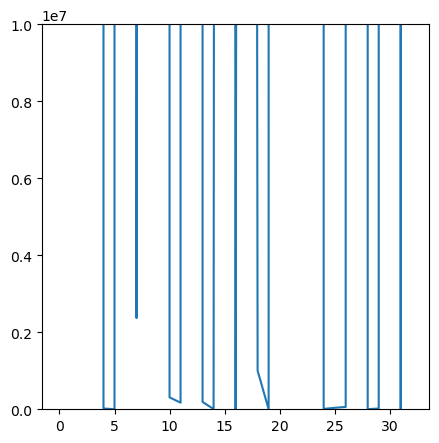

In [61]:
# load trained Unet
# net = UNet(3, 17).to(device)
# net.load_state_dict(torch.load('unet_3.pth'))
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(loss_history)
ax.set(ylim=[0, 10000000])


In [41]:
torch.save(net.state_dict(), "Unet_batch4_2.pth")

In [104]:
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [106]:
# load one set of data from dataloader to check 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 =next(iter(dataloader_test))

K = K.to(device)
pose_10 = invert_pose(pose_01)

# set inital guess as identity rot-vec. and 0 translation
result_q0 = torch.zeros(len(K), 6, device=device)
result_q1 = torch.zeros(len(K), 6, device=device)

pyramid_q = net.forward(image_q.to(device))
pyramid_0 = net.forward(image_0.to(device))

level = 3
iteration = 16

features_q, saliency_q = pyramid_q[3]
features_0, saliency_0 = pyramid_0[3]

# Resample depth maps for pyramid
size = features_q.shape[-2:]
depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

# Align image_0 to query image
residuals_q0 = align_feature_maps(K, features_q, saliency_q, features_0, saliency_0, depth_0_, gamma=0.02)
result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iteration, damping=abs(0.00634))
pose_q0_est = pose_from_params(result_q0)

In [107]:
# reproject using pose_q0_est
reprojected_query_image = reproject(depth_q.to(device), image_q.to(device), K.to(device), pose_q0_est)

Text(0.5, 1.0, 'query image')

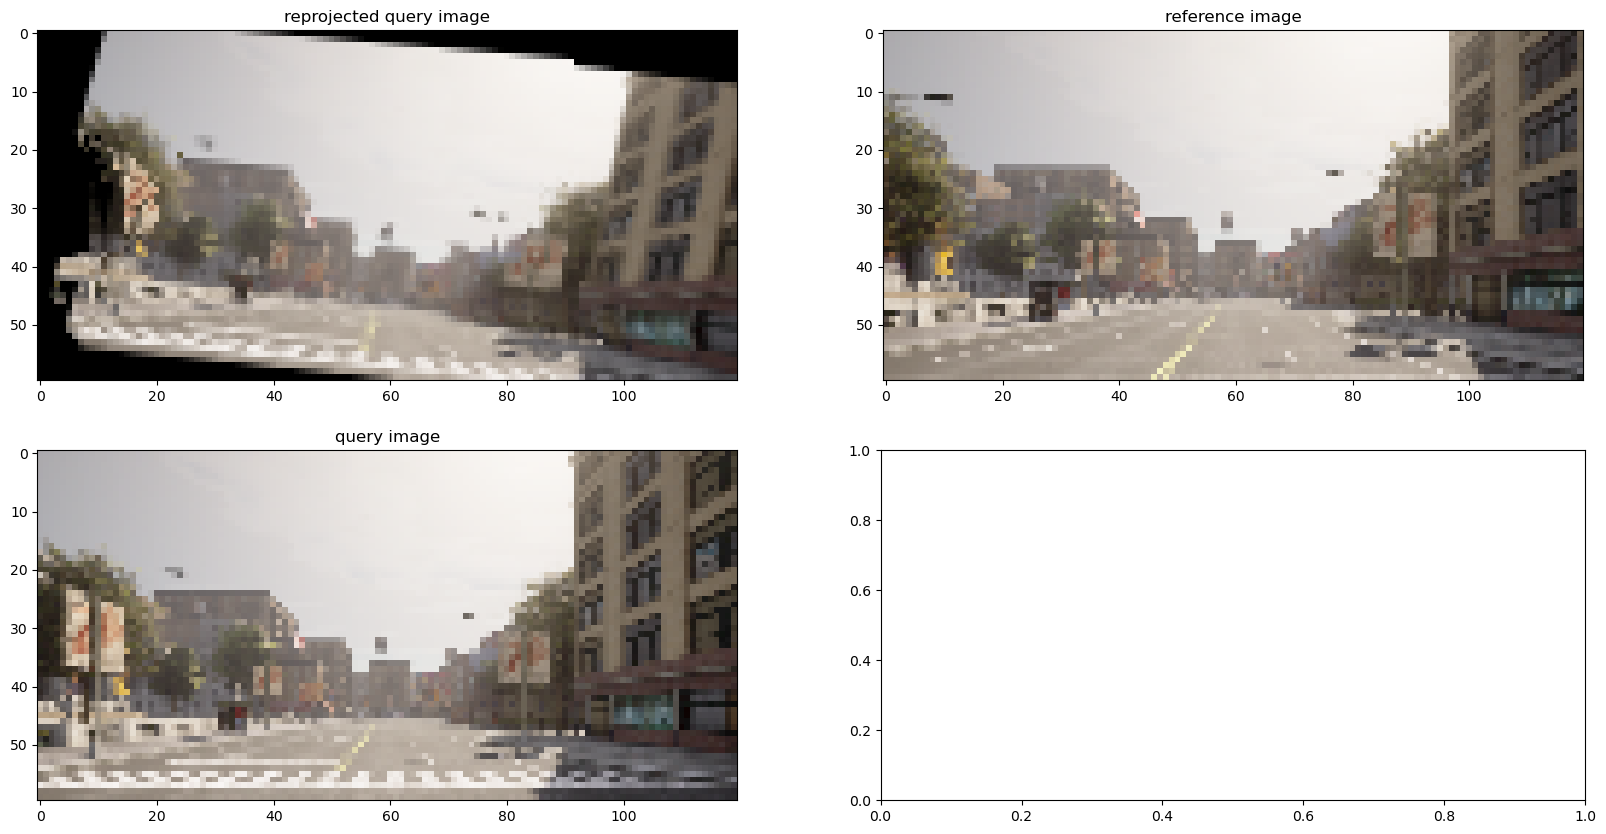

In [109]:
fig,ax =  plt.subplots(2,2,figsize=(20,10))
ax[0,0].imshow(reprojected_query_image.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[0,1].imshow(image_0.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[1,0].imshow(image_q.cpu().detach().squeeze().permute(1,2,0).numpy())
ax[0,0].set_title('reprojected query image')
ax[0,1].set_title('reference image')
ax[1,0].set_title('query image')


In [ ]:
# del pyramid_0
# del pyramid_q
del residuals_q0
# del net
torch.cuda.empty_cache()
import gc
gc.collect()


112

In [ ]:
net = UNet(3, 17).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:

net.load_state_dict(torch.load('/content/drive/MyDrive/unet_3.pth'))

FileNotFoundError: ignored

In [ ]:
#batch = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, pose_q0, pose_q1, pose_01 =next(iter(dataloader))
# result_q0.get_device(),K.get_device()
# result_q0 = (torch.zeros(len(K), 6, device=device),torch.zeros(len(K), 6, device=device))

pyramid_q = net.forward(image_q.to(device))
pyramid_0 = net.forward(image_0.to(device))



level = 3
iteration = 16

features_q, saliency_q = pyramid_q[3]
features_0, saliency_0 = pyramid_0[3]

size = features_q.shape[-2:]
depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(1)# change size to 2,1,600,800



In [ ]:

result_q0 = torch.zeros(len(K), 6, device=device)

In [ ]:
# Resample depth maps for pyramid

# Align image_0 to query image
residuals_q0 = align_feature_maps(K.to(device), features_q, saliency_q, features_0, saliency_0, depth_0_, gamma=0.02)
result_q0 = gauss_newton_batch(result_q0, residuals_q0, iterations=iteration, damping=abs(0.00634))
pose_q0_est = pose_from_params(result_q0)

x.squeeze.shape tensor([-40.1861,  -2.3261,  27.5328, 878.9727,  16.3921,  -7.3170],
       device='cuda:0', grad_fn=<UnbindBackward0>)
output.shape torch.Size([2, 6])


OutOfMemoryError: ignored

In [ ]:
pose_q0_est
# size = features_q.shape[-2:]
# depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

(tensor([[[ 0.7028,  0.5994, -0.3832],
          [-0.5266,  0.0761, -0.8467],
          [-0.4783,  0.7968,  0.3691]],
 
         [[ 0.7028,  0.5994, -0.3832],
          [-0.5266,  0.0761, -0.8467],
          [-0.4783,  0.7968,  0.3691]]], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>), tensor([[[878.9727],
          [ 16.3921],
          [ -7.3170]],
 
         [[878.9727],
          [ 16.3921],
          [ -7.3170]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>))

In [ ]:

depth_0_.shape, features_q.shape[-2:]

(torch.Size([1, 2, 600, 800]), torch.Size([600, 800]))

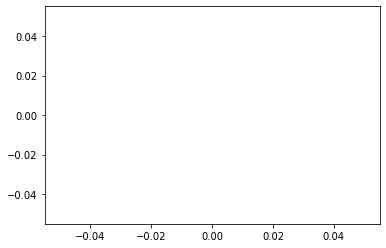

In [ ]:
import matplotlib.pyplot as plt

trace = np.array(loss_history)
plt.plot(trace[trace < 20][500:])
plt.show()

In [ ]:
torch.save(net.state_dict(),'unet_2.pth')

## Test

Test all the things!

Test Transform consistency loss